## Naive Bayes Classifier

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.naive_bayes as nb
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


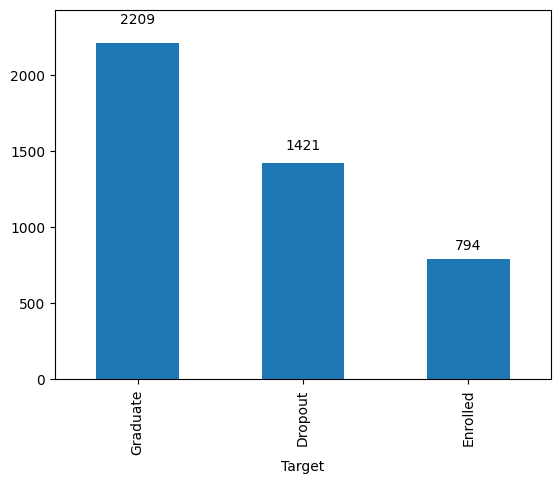

In [2]:
# Load the data
# preprocessing data
df = pd.read_csv('dataset.csv')
df = df.dropna()

# Make bar graphs of the counts of the Target variable
counts = df['Target'].value_counts()
bars = counts.plot(kind='bar')

for i, v in enumerate(counts):
    bars.text(i, v + 0.05*v, str(v), ha='center', va='bottom')  # Adjust y-position of the text

plt.ylim(0, max(counts)*1.1)  # Adjust y-limit of the plot
plt.show()

df = df[~df['Target'].str.contains('Enroll')].copy()
df['Target'] = df['Target'].map({'Dropout': 0, 'Graduate': 1})

12


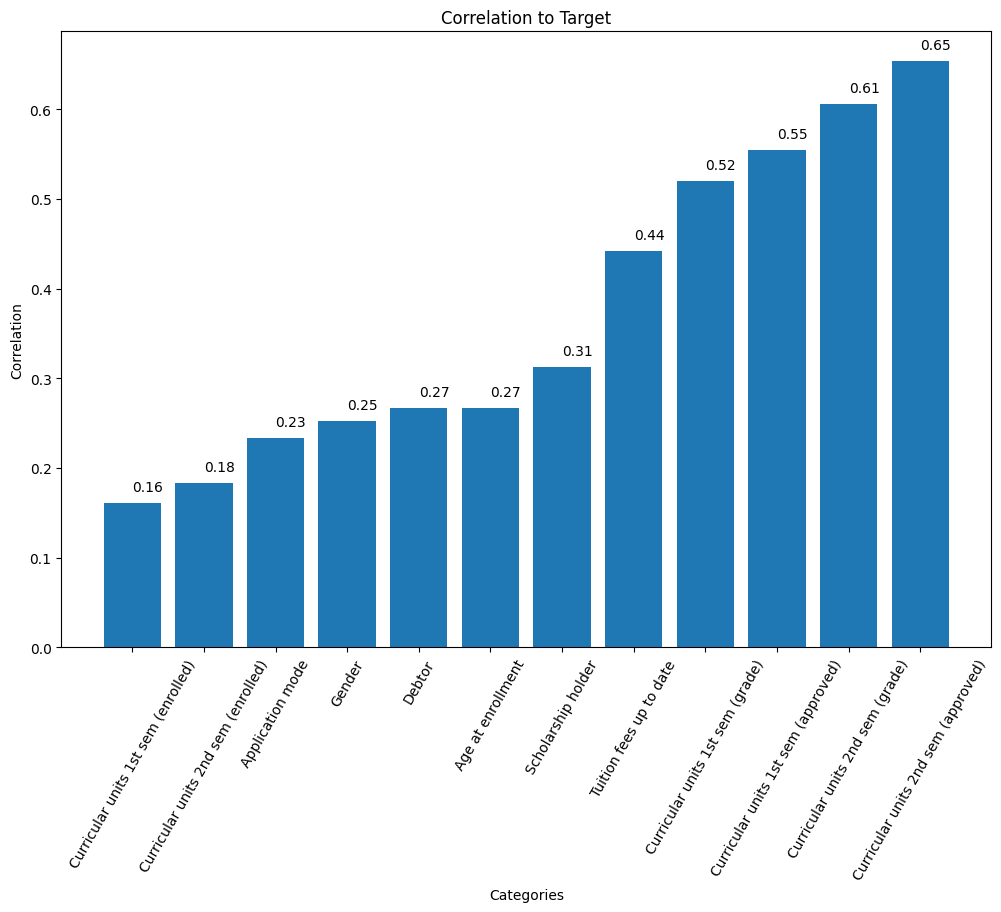

In [3]:
correlation_to_target = df.corr()['Target'].drop('Target')
high_correlation = correlation_to_target[abs(correlation_to_target) > 0.15]
print(len(high_correlation))
high_correlation = abs(high_correlation)

# plot the correlation of all features with > 0.15 correlation to the target
plt.figure(figsize=(12,8))
bars = plt.bar(high_correlation.sort_values().index, high_correlation.sort_values().values)
plt.title('Correlation to Target')
plt.xlabel('Categories')
plt.ylabel('Correlation')

for bar in bars:
    yval = bar.get_height()
    if yval < 0:  # Adjust vertical alignment for negative values
        alignment = 'top'
        ytext = yval - 0.01
    else:
        alignment = 'bottom'
        ytext = yval + 0.01
    plt.text(bar.get_x() + bar.get_width()/2.0, ytext, round(yval, 2), va=alignment)

plt.xticks(rotation=60)  # Rotate x-axis labels

plt.show()

In [4]:
# mutate the dataframe to contain the 12 highest correlated columns and the target
df_corr = df[high_correlation.index]
df_final = pd.concat([df_corr, df['Target']], axis=1)

X = df_final.drop('Target', axis=1)
Y = df_final['Target']


In [5]:
# Create a Naive Bayes classifier
classifier = nb.GaussianNB()

Kfold = 5

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X, Y, cv=Kfold)
# accuracy with 95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.02)


In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes classifier
classifier = nb.GaussianNB()

Kfold = 5

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X, Y, cv=Kfold)
# accuracy with 95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.01)


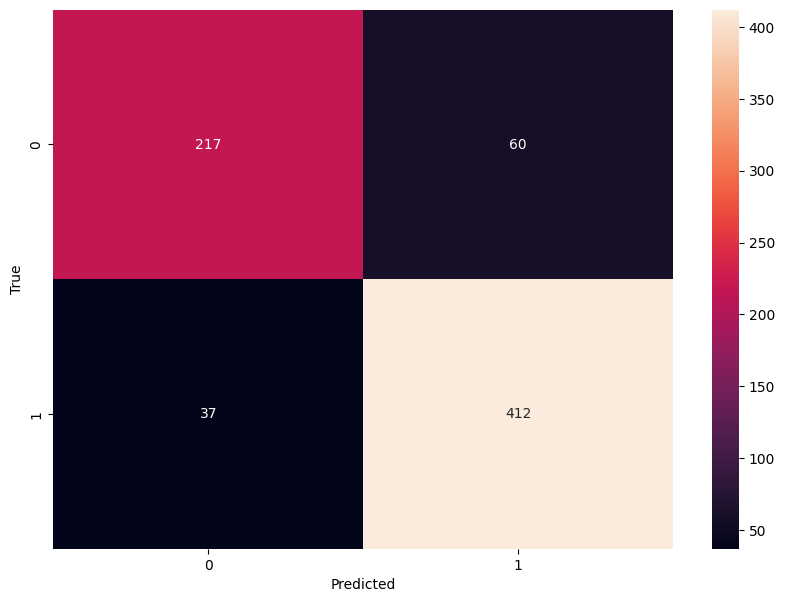

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       277
           1       0.87      0.92      0.89       449

    accuracy                           0.87       726
   macro avg       0.86      0.85      0.86       726
weighted avg       0.87      0.87      0.87       726



In [31]:
# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

## PCA

In [9]:
processed_data = df.copy()
processed_data.drop(['International',
           'Nacionality',
           "Mother's qualification",
           "Curricular units 1st sem (evaluations)",
           "Mother's occupation",
           "Father's occupation",
           "Father's qualification",
           'Unemployment rate',
           "Application order",
           "GDP",
           'Inflation rate'],axis=1,inplace=True)

processed_data.loc[:, 'Target_Binary'] = processed_data['Target'].apply(lambda x: 0 if x == "Dropout" else 1)
exploration_data = processed_data.drop(columns=["Target", "Target_Binary"])

In [13]:
# Perform feature scaling prior to PCA
# mean center the data and divide by the standard deviation
def feature_scale(X):
    # X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # return X_scaled
    return X

data_scaled = feature_scale(exploration_data.iloc[:, 1:])

# Perform PCA
data_cov = np.cov(data_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(data_cov)

# Sort the eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigvals = eigenvalues[sorted_indices]
sorted_eigvecs = eigenvectors[:, sorted_indices]


In [40]:
# top_20_eigvecs = sorted_eigvecs[:, :10]
top_eigvecs = sorted_eigvecs[:, :12]

# Project the data onto the top 20 eigenvectors
# data_proj = np.dot(data_scaled, top_20_eigvecs)
data_proj = np.dot(data_scaled, top_eigvecs)

# Reconstruct the data using the top 20 eigenvectors
# data_reconstructed = np.dot(data_proj, top_20_eigvecs.T)

data_reconstructed = np.dot(data_proj, top_eigvecs.T)
data_reconstructed = pd.DataFrame(data_reconstructed, columns=exploration_data.columns[1:])

In [47]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_reconstructed, Y, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes classifier
classifier = nb.GaussianNB()

Kfold = 5

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X, Y, cv=Kfold)
# accuracy with 95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.01)


In [49]:
# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8677685950413223


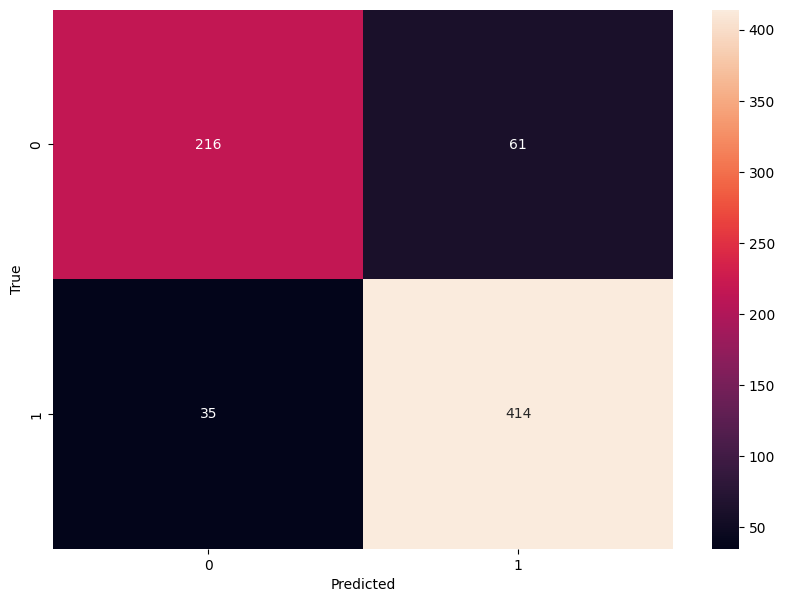

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       277
           1       0.87      0.92      0.90       449

    accuracy                           0.87       726
   macro avg       0.87      0.85      0.86       726
weighted avg       0.87      0.87      0.87       726



In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)